## Module 19: Learning Notebook: Introduction to Multilayer Perceptron (MLP)

Maybe you've heard of a 'Neural Network'? MLP is a type of Neural Network.  Maybe you've heard of an ANN (Artificial Neural Network). Same thing.  I would just say that MLP is an implementation of a Neural Network. <P>
    
An MLP consists of at least three layers of nodes: an input layer (your data features), one or more hidden layers and an output layer (your target). Except for the input nodes, each node is a neuron that uses a nonlinear activation function. This means it finds complex relationships between the features and targets. MLP utilizes a supervised learning technique called backpropagation for training. You can do both classification and regression with MLP.<P>
    
<img src="images/mlp.png" width=450 height=450 /><BR>


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import boto3
import pandas as pd
import numpy as np
import seaborn as sns

### 1. Load and Prepare data

In [3]:
# Load from S3
sess = boto3.session.Session()
s3 = sess.client('s3') 
source_bucket = 'machinelearning-read-only'
source_key = 'data/cancer-10.csv' 
response = s3.get_object(Bucket = source_bucket, Key = source_key)
df = pd.read_csv(response.get("Body"))
print('df size (rows, columns):',df.shape)
df.head(3)

df size (rows, columns): (1000, 7)


,gene1,gene2,gene3,gene4,gene5,gene6,cancer_detected
0,3.447535,14.196807,80.524611,-36.487496,289.932591,146.273690,0
1,3.276234,17.705782,72.786907,-63.487129,293.618375,90.953863,0
2,4.036522,14.942696,67.819683,-48.681795,249.619909,165.576714,0


In [4]:
# Prepare data
X = df.drop(['cancer_detected'], axis = 1)
y = df['cancer_detected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 7)
# Verify the sizes of the split datasets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (800, 6)
y_train: (800,)
X_test: (200, 6)
y_test: (200,)


### 2. Create the MLP Model
Hyperparameters to discuss:
- hidden_layer_sizes
- max_iter
- solver

In [5]:
# Model using MLP
#   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
mlp = MLPClassifier(max_iter = 500, hidden_layer_sizes = (1,), solver = 'adam', random_state = 43)
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=43, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [6]:
# Remember, in the test set, we are trying to predict the 18 patients with cancer detected
y_test.value_counts()

0    182
1     18
Name: cancer_detected, dtype: int64

In [7]:
# Setup a pipeline, train then evaluate the model
scaler = StandardScaler() # Standardize the data
steps = [('Scaler', scaler), ('MLP', mlp)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('MLP accuracy:', round(acc,4))
confusion_matrix(y_test, y_pred,labels = [1,0])

MLP accuracy: 0.91


array([[  0,  18],
       [  0, 182]])

### 3. Tune the 3 hyperparameters using GridSearchCV, from a previous lesson

In [8]:
# Setup the pipeline
scaler = StandardScaler()
mlp = MLPClassifier()
pipe = Pipeline(steps=[("Scaler", scaler), ("MLP", mlp)])
#
# Define the range of parameters to evaluate
parameters = {
    "MLP__hidden_layer_sizes":[(2,),(100,),(100,100)],
    "MLP__max_iter":[1500,2000],
    "MLP__solver":["adam","lbfgs"]
}
cv = GridSearchCV(pipe, parameters, cv = 5)
cv.fit(X,y.values.ravel()) 
# Show the results of the search
print('Best Score:', cv.best_score_)
print('Best parameter values:', cv.best_params_)

Best Score: 0.943
Best parameter values: {'MLP__hidden_layer_sizes': (100, 100), 'MLP__max_iter': 2000, 'MLP__solver': 'adam'}


### 4. With the best tuned parameters, train and evaluate the MLP

In [9]:
# Again, trying to catch the 18 cases of detectd cancer
y_test.value_counts()

0    182
1     18
Name: cancer_detected, dtype: int64

In [10]:
mlp = MLPClassifier(max_iter = 1500, hidden_layer_sizes = (100,), solver = 'adam', random_state = 43)
scaler = StandardScaler() # Standardize the data
steps = [('Scaler', scaler), ('MLP', mlp)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('MLP accuracy:', round(acc,4))
confusion_matrix(y_test, y_pred,labels = [1,0])

MLP accuracy: 0.945


array([[  9,   9],
       [  2, 180]])

### 5. Evaluate the ROC and AUC

In [11]:
# Predict the probabilities instead of the lables
mlp_y_pred_prob = pipe.predict_proba(X_test)

# auc score
auc_score = roc_auc_score(y_test, mlp_y_pred_prob[:,1])
print('MLP AUC Score:', round(auc_score,3))

MLP AUC Score: 0.882


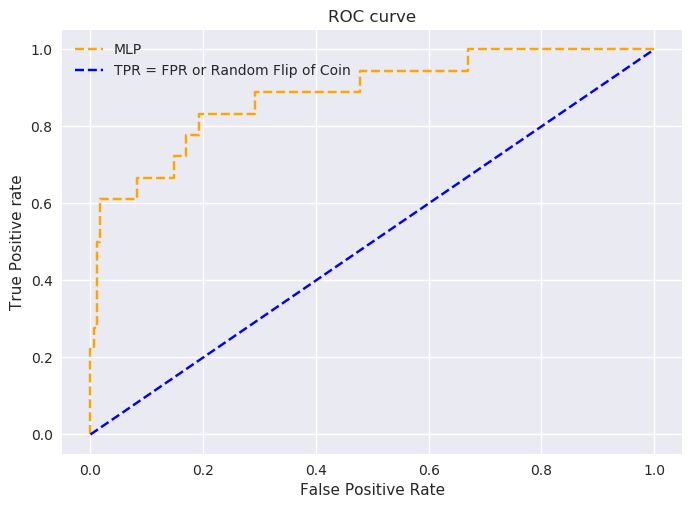

In [12]:
# Generate points for ROC curves for models
fpr, tpr, thresh = roc_curve(y_test, mlp_y_pred_prob[:,1], pos_label=1) # y_test & P(1)
#gbc_fpr, gbc_tpr, gbc_thresh = roc_curve(y_test, gbc_y_pred_prob[:,1], pos_label=1)
#
# roc curve for tpr = fpr (Straight line, like flipping a coin)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
#
# Code to plot those points
# matplotlib
#import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='MLP')
#plt.plot(gbc_fpr, gbc_tpr, linestyle='--',color='green', label='Gradient Boosting Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='TPR = FPR or Random Flip of Coin')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### 6. Evalute different thresholds

In [13]:
# Let's iterate over the theshold values of .1 to .95 and evalute how the predictions to for each threshold
for i in np.arange(.05, .95, 0.05):
    thresh = i # Set the threshold
    temp_pred = (pipe.predict_proba(X_test)[:,1] >= thresh).astype(int) # This accepts as True if over threshold
    # Now print the confusion matrix
    # Remember, for cancer detection, we really want to avoid not identifying cancer
    print('Confusion Matrix for threshold = :', round(thresh,2),' \n', confusion_matrix(y_test, temp_pred,labels = [1,0]),'\n')

Confusion Matrix for threshold = : 0.05  
 [[ 12   6]
 [ 20 162]] 

Confusion Matrix for threshold = : 0.1  
 [[ 11   7]
 [ 13 169]] 

Confusion Matrix for threshold = : 0.15  
 [[ 11   7]
 [ 10 172]] 

Confusion Matrix for threshold = : 0.2  
 [[ 11   7]
 [  6 176]] 

Confusion Matrix for threshold = : 0.25  
 [[ 11   7]
 [  6 176]] 

Confusion Matrix for threshold = : 0.3  
 [[ 11   7]
 [  4 178]] 

Confusion Matrix for threshold = : 0.35  
 [[ 10   8]
 [  3 179]] 

Confusion Matrix for threshold = : 0.4  
 [[  9   9]
 [  3 179]] 

Confusion Matrix for threshold = : 0.45  
 [[  9   9]
 [  3 179]] 

Confusion Matrix for threshold = : 0.5  
 [[  9   9]
 [  2 180]] 

Confusion Matrix for threshold = : 0.55  
 [[  8  10]
 [  2 180]] 

Confusion Matrix for threshold = : 0.6  
 [[  6  12]
 [  2 180]] 

Confusion Matrix for threshold = : 0.65  
 [[  6  12]
 [  2 180]] 

Confusion Matrix for threshold = : 0.7  
 [[  5  13]
 [  2 180]] 

Confusion Matrix for threshold = : 0.75  
 [[  5  13]
 